# Предсказание оттока пользователей

Нам предстоит моделировать отток клиентов телеком-компании. Эта задача очень важна на практике: если мы знаем, что клиент собирается уйти от нас, то мы можем попытаться удержать его, предложив какие-то бонусы.

In [1]:
import warnings
warnings.simplefilter(action='ignore')

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, average_precision_score, confusion_matrix, roc_curve, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer, MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer, QuantileTransformer, OneHotEncoder 
from sklearn.decomposition import TruncatedSVD
from sklearn.dummy import DummyClassifier
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import mutual_info_classif

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from statsmodels.stats.outliers_influence import variance_inflation_factor

from catboost import CatBoostClassifier

from category_encoders.cat_boost import CatBoostEncoder

import umap

2022-10-25 13:52:33.423569: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
RANDOM_STATE=177013

In [4]:
# Для нашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

# Обзор данных

## Предварительное ознакомление

Загрузим данные и изучим общую информацию и небольшую случайную выборку строк:

In [5]:
data = pd.read_csv('train.csv')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [7]:
data.sample(n=10)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
3510,18,61.50,1087.45,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,No,Yes,No,No,One year,Yes,Mailed check,0
1472,50,69.50,3418.2,Male,0,No,No,Yes,Yes,DSL,No,No,Yes,Yes,No,Yes,Two year,No,Bank transfer (automatic),0
958,11,40.40,422.6,Female,0,No,No,No,No phone service,DSL,No,Yes,Yes,Yes,No,No,One year,Yes,Credit card (automatic),0
2139,43,24.25,1077.95,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1440,71,105.75,7382.85,Male,1,No,No,Yes,Yes,Fiber optic,No,Yes,No,Yes,Yes,Yes,One year,No,Bank transfer (automatic),0
1787,49,88.20,4159.45,Male,1,Yes,No,Yes,Yes,Fiber optic,Yes,Yes,Yes,No,No,No,Month-to-month,Yes,Electronic check,0
1268,58,108.85,6287.25,Male,1,Yes,No,Yes,Yes,Fiber optic,Yes,Yes,Yes,No,Yes,Yes,One year,Yes,Electronic check,1
1889,60,60.80,3603.45,Female,0,Yes,No,No,No phone service,DSL,No,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0
636,35,19.70,730.4,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2148,7,89.50,676.7,Male,1,Yes,No,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,1


Проверим данные на пропуски и дубликаты:

In [8]:
data.isna().mean()

ClientPeriod                0.0
MonthlySpending             0.0
TotalSpent                  0.0
Sex                         0.0
IsSeniorCitizen             0.0
HasPartner                  0.0
HasChild                    0.0
HasPhoneService             0.0
HasMultiplePhoneNumbers     0.0
HasInternetService          0.0
HasOnlineSecurityService    0.0
HasOnlineBackup             0.0
HasDeviceProtection         0.0
HasTechSupportAccess        0.0
HasOnlineTV                 0.0
HasMovieSubscription        0.0
HasContractPhone            0.0
IsBillingPaperless          0.0
PaymentMethod               0.0
Churn                       0.0
dtype: float64

In [51]:
df = pd.DataFrame()

In [52]:
for i in data.columns:
    print(len(df.columns), i, data[i].isna().sum())
    df.insert(loc=len(df.columns), column=i, value=[data[i].isna().sum()])

0 ClientPeriod 0
1 MonthlySpending 0
2 TotalSpent 0
3 Sex 0
4 IsSeniorCitizen 0
5 HasPartner 0
6 HasChild 0
7 HasPhoneService 0
8 HasMultiplePhoneNumbers 0
9 HasInternetService 0
10 HasOnlineSecurityService 0
11 HasOnlineBackup 0
12 HasDeviceProtection 0
13 HasTechSupportAccess 0
14 HasOnlineTV 0
15 HasMovieSubscription 0
16 HasContractPhone 0
17 IsBillingPaperless 0
18 PaymentMethod 0
19 Churn 0


In [54]:
df.T

,0
ClientPeriod,0
MonthlySpending,0
TotalSpent,0
Sex,0
IsSeniorCitizen,0
HasPartner,0
HasChild,0
HasPhoneService,0
HasMultiplePhoneNumbers,0
HasInternetService,0


In [9]:
data.duplicated().sum()

14

### Вывод

1. Предоставлены данных о 5282 клиентах по 20 признакам (в том числе 3 числовым и 17 категориальным, 6 из которых бинарны). Целевой признак `Churn` тоже бинарный. Все рабочие признаки выглядят потенциально полезными для моделирования. Заголовки столбцов удовлетворительны. Категория `IsSeniorCitizen` записана, в отличие от остальных, в виде числа, что желательно поправить по эстетическим соображениям.

2. Явных пропусков не наблюдается, однако подозрительно выглядит столбец `TotalSpent`, где числа записаны в виде строк, - возможно, не все они корректны.

3. В таблице 14 повторяющихся строк. Хотя у нас нет уникального идентификатора клиента, совпадение вплоть до потраченных копеек выглядит подозрительно - целесообразно эти строки удалить.

### Первичная предобработка

Удалим из датасета дубликаты:

In [10]:
data = data.drop_duplicates()

Теперь посмотрим, можно ли надежно перевести столбец `TotalSpent` в числовой вид:

In [11]:
pd.to_numeric(data['TotalSpent'].str.strip()).isna().sum()

9

В 9 строках пробел, но забегая немного вперед, заметим, что `TotalSpent` хорошо объясняется произведением значений `MonthlySpending` на `ClientPeriod`, что дает возможность эти пропуски заполнить:

In [12]:
fill_vector = data.apply(lambda row: row['MonthlySpending'] * row['ClientPeriod'], axis=1)

In [13]:
data['TotalSpent'] = pd.to_numeric(data['TotalSpent'].str.strip()).fillna(fill_vector)

И напоследок приведем столбец `IsSeniorCitizen` к тому же виду, что и остальные категории.

In [14]:
data['IsSeniorCitizen'] = data['IsSeniorCitizen'].map(lambda x: 'Yes' if x else 'No')

## EDA

### Численные признаки

In [15]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
ClientPeriod,5268.0,32.480448,24.529439,0.00,9.0000,29.00,55.0000,72.00
MonthlySpending,5268.0,64.977563,30.176025,18.25,35.5375,70.45,90.0500,118.75
TotalSpent,5268.0,2293.445549,2269.111393,0.00,401.9250,1411.50,3808.6375,8684.80
Churn,5268.0,0.260820,0.439124,0.00,0.0000,0.00,1.0000,1.00


In [16]:
def visualize_numeric(df, columns):
    fig, axes = plt.subplots(1, 3, figsize=(9,3), constrained_layout=True)
    for column, ax in zip (df[columns], axes.flat):
        sns.histplot(bins='fd',data=df[column], ax=ax).set(xlabel=column, ylabel='Наблюдений, шт.', xlim=(0))
    fig.suptitle('Численные признаки: гистограммы')
    fig, axes = plt.subplots(1, 3, figsize=(9,3), constrained_layout=True)
    for column, ax in zip (df[columns], axes.flat):
        sns.violinplot(data=df[column], ax=ax, orient='h').set(xlabel=column)
    fig.suptitle('Численные признаки: плотность и размах')

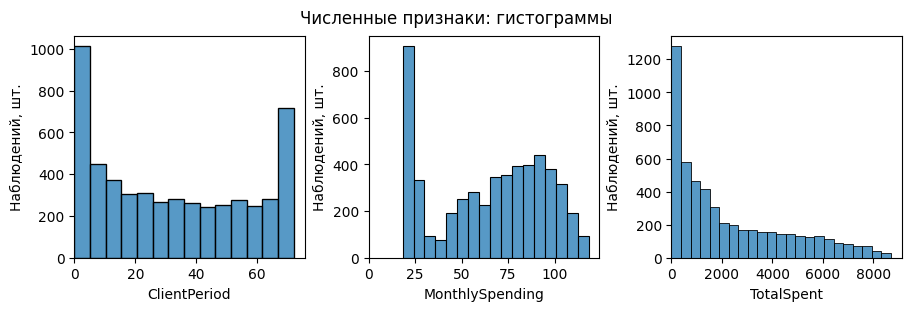

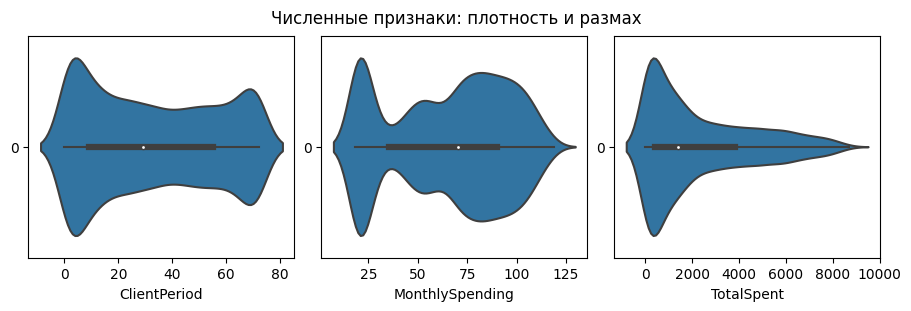

In [17]:
visualize_numeric(data, num_cols)

Значения столбца `ClientPeriod` имеют занятное бимодальное распределение: много свежих клиентов, и в то же время много с макимальным значением параметра (72). Не совсем понятно, полный ли это клиентский стаж (видимо, в месяцах), где 6 лет симовлизирует "6 и выше", или просто окно стастистики. В среднем "клиентский" стаж равен примерно 32.5 (29 по медиане), половина значений лежит в диапазоне от 9 до 55.

`MonthlySpending` (расходы за месяц) показывают даже три моды: около нуля, чуть выше 50 и в районе 80 единиц, со средним около 65 (70.45 по медиане). Стоит отметить, что минимальные расходы не опускаются ниже 18.25, а 75% значений не превышает 90.

`TotalSpent` (суммарные расходы?) распределением напоминает логнормальное, с большим количеством околонулевых значений - при среднем около 2300 медиана составляет всего 1411.5, больинство значений не превышает 3800, однако "хвост" тянется почти до 8700.

Возникает вопрос: насколько зависимы эти столбцы?

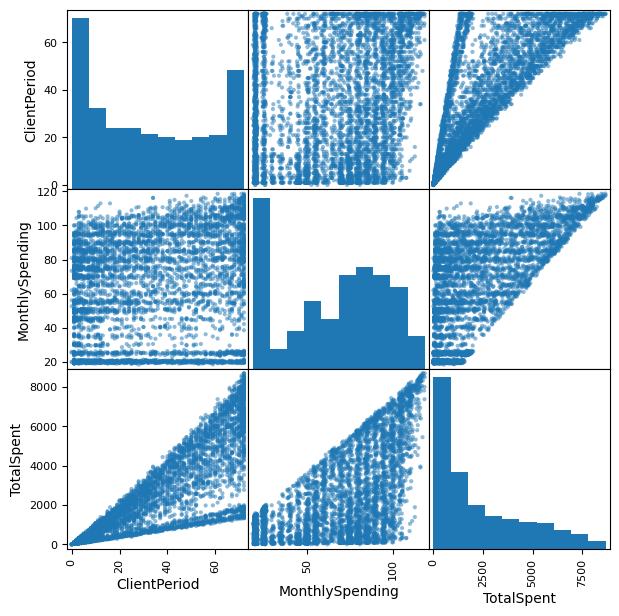

In [18]:
pd.plotting.scatter_matrix(data[num_cols], figsize=(7,7));

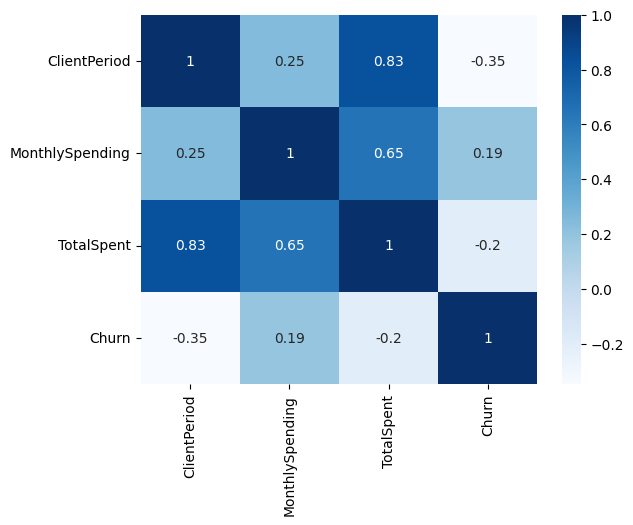

In [19]:
sns.heatmap (data.corr(), cmap='Blues', annot=True);

Корреляция значений довольно сильная (можно также отметить намек на то, что старые клиенты уходят реже, а те, кто сильно поистратился за месяц - чаще). `TotalSpent` хорошо объясняется как произведение двух других численных признаков, но не идеально: 

In [20]:
(data['TotalSpent'] / data['ClientPeriod']).corr(data['MonthlySpending'])

0.9963311111717983

In [21]:
ratio = data['TotalSpent'] / data['ClientPeriod'] / data['MonthlySpending']

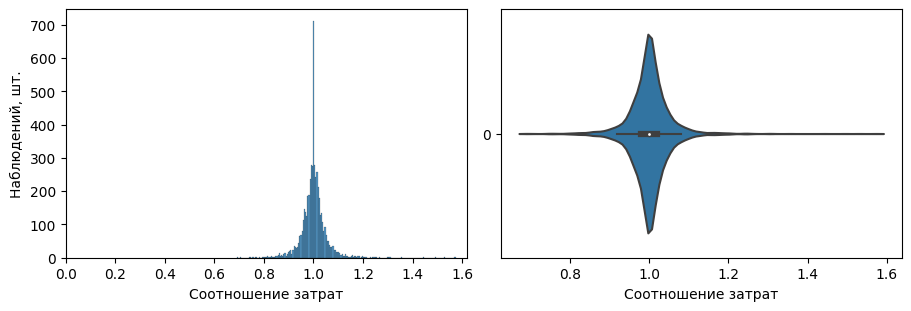

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(9,3), constrained_layout=True)
sns.histplot(bins='fd', data=ratio, ax=axes.flat[0]).set(xlabel='Соотношение затрат', ylabel='Наблюдений, шт.', xlim=(0))
sns.violinplot(data=ratio, ax=axes.flat[1], orient='h').set(xlabel='Соотношение затрат');

По-видимому, `MonthlySpending` символизирует расходы последнего месяца, а отношение `TotalSpent` к стажу - исторические данные (на это намекает и тот факт, что в `TotalSpent` есть нули, которых в `MonthlySpending` нет). В среднем два показателя очень близки! Есть и отклонения, в редких случаях разница между текущим месяцем и предыдущими может быть и в полтора раза.

## Категориальные признаки

In [23]:
def visualize_categorical(df, columns):
    fig, axes = plt.subplots(8, 2, figsize=(8,24), constrained_layout=True)
    for column, ax in zip (df[cat_cols], axes.flat):
        df[column].value_counts().plot(kind='bar', ax=ax, rot=45 if column=='PaymentMethod' else 0).set(title=column)
        #plt.setp(ax.get_xticklabels(), fontsize=8) #, rotation='vertical'
    fig.suptitle('Категориальные признаки: распределение')

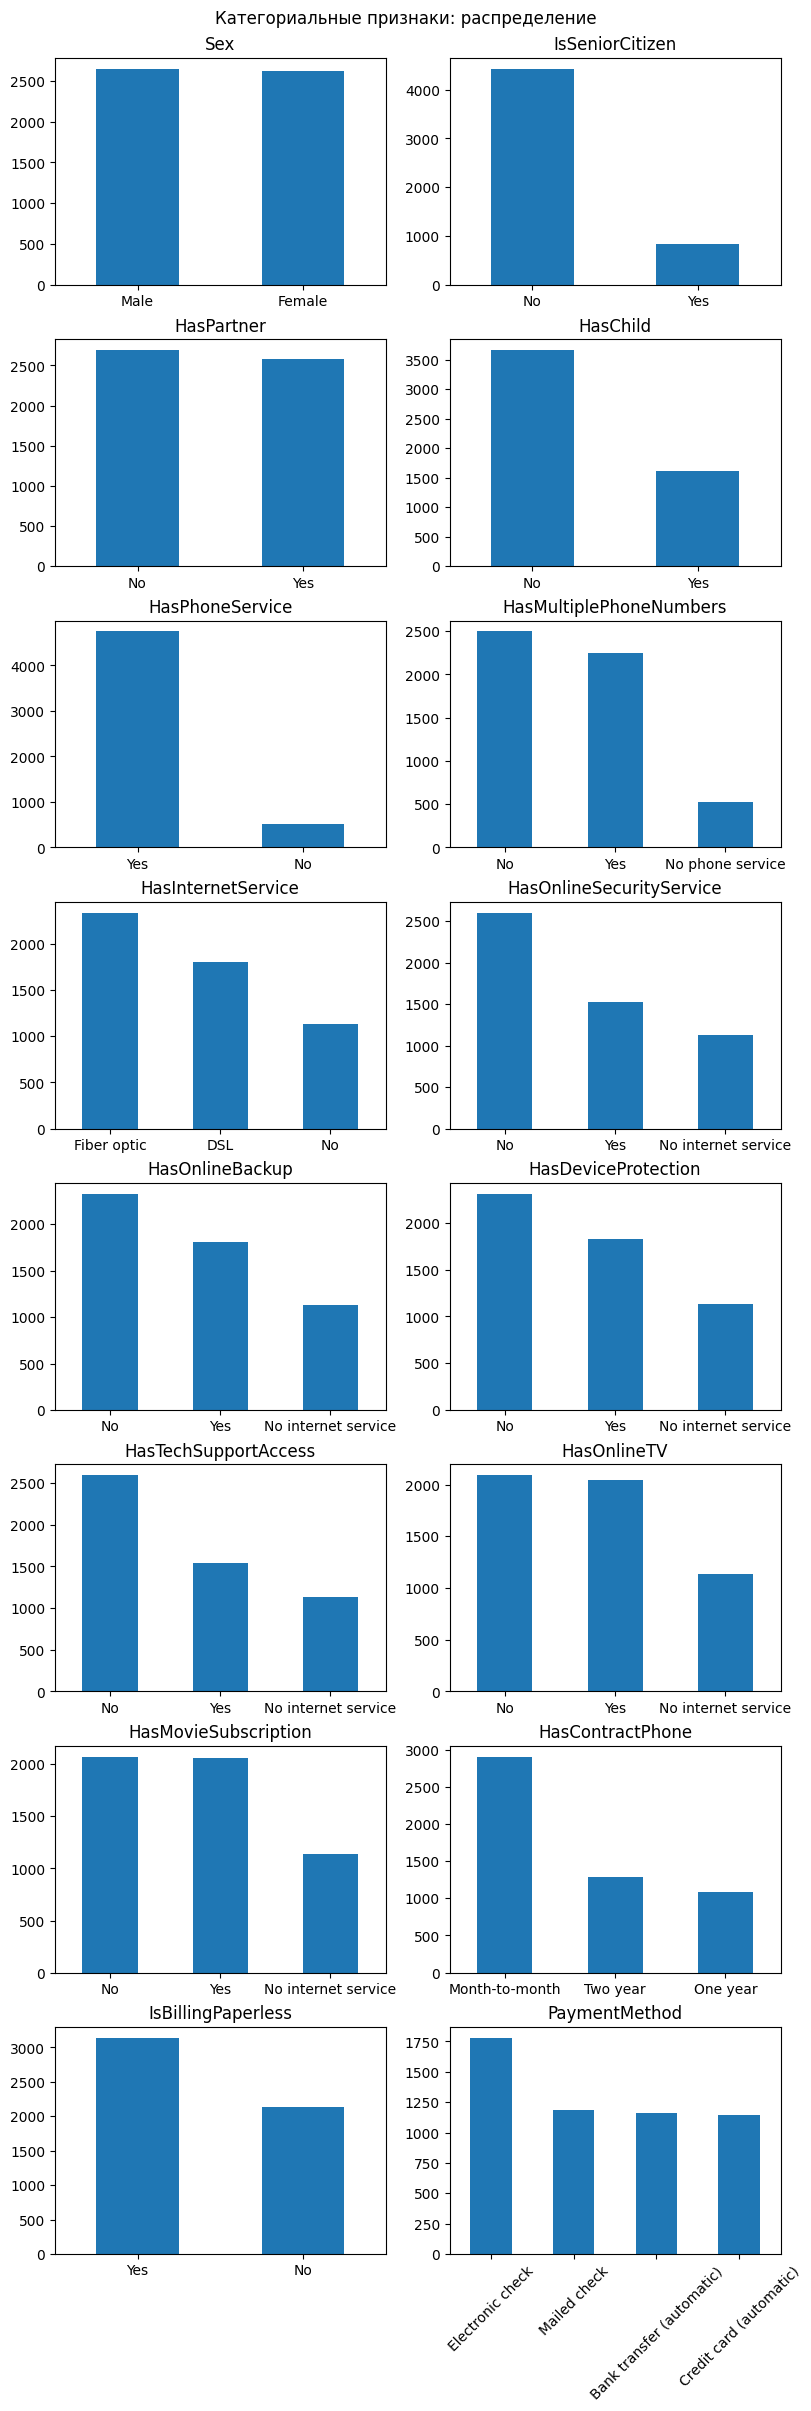

In [24]:
visualize_categorical(data, cat_cols)

Распределение по категориям вполне наглядное и в особых комментариях не нуждается. А вот наличие категории `No phone service`/`No internet service` создает проблему для моделирования: вполне очевидно, что при кодировании переменных мы рискуем получить пачку полностью идентичных столбцов.

## Распределение классов

0    3894
1    1374
Name: Churn, dtype: int64

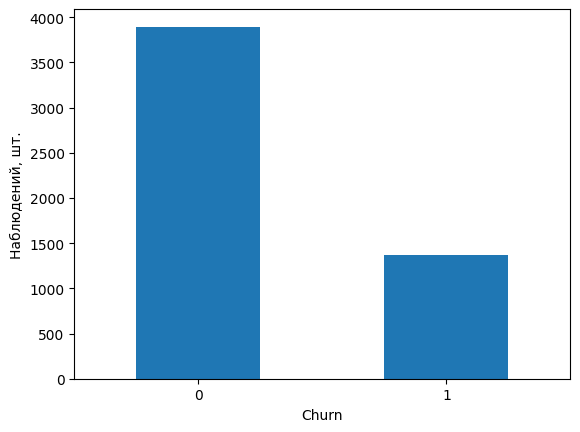

In [25]:
data[target_col].value_counts().plot(kind='bar', rot=0).set(xlabel=target_col, ylabel='Наблюдений, шт.');
data[target_col].value_counts()

Дисбаланс классов присутствует: ушедших клиентов порядка четверти от общего числа наблюдений. Количества примеров положительного класса более чем достаточно для генерализации, а наша целевая метрика порогонезависима, но тем не менее, мы включим развесовку в набор гиперпараметров для оптимизации.

## Feature selection

Как мы разобрали выше, численные признаки хорошо объясняют друг друга, но при этом не стопроцентно избыточны. Некоторые категории же создают риск появления идентичных столбцов при кодировании. Поступим с ними следующим образом:

- к численным признакам применим понижение размерности через TruncatedSVD;
- значения категорий `No phone service`/`No internet service` заменим на `No`.

In [26]:
columns_with_redundancy = ['HasMultiplePhoneNumbers', 'HasOnlineSecurityService', 'HasOnlineBackup',
                            'HasDeviceProtection', 'HasTechSupportAccess', 'HasOnlineTV', 'HasMovieSubscription']

In [27]:
def eliminate_redundancy(df, columns):
    for column in columns:
        df[column] = df[column].apply(lambda x: 'No' if x not in ['Yes','No'] else x)
    return df

In [28]:
def one_hot_encoding(df, columns):
    dummies = pd.get_dummies(df[columns], drop_first=True)
    df[dummies.columns] = dummies
    return df

def drop_unused_columns (df, column_list):
    return df.drop (column_list, axis=1)

In [29]:
clean_df = (
            data.copy()
            .pipe(eliminate_redundancy, columns_with_redundancy)
            .pipe(one_hot_encoding, cat_cols)
            .pipe(drop_unused_columns, cat_cols)
            )

In [30]:
data = (
        data.pipe(eliminate_redundancy, columns_with_redundancy)
       )

In [31]:
svd = TruncatedSVD(n_components=1)
clean_df['svd'] = svd.fit_transform(clean_df[num_cols], clean_df[target_col])

In [32]:
clean_df = clean_df.drop(num_cols, axis=1)

In [33]:
clean_df

,Churn,Sex_Male,IsSeniorCitizen_Yes,HasPartner_Yes,HasChild_Yes,HasPhoneService_Yes,HasMultiplePhoneNumbers_Yes,HasInternetService_Fiber optic,HasInternetService_No,HasOnlineSecurityService_Yes,...,HasTechSupportAccess_Yes,HasOnlineTV_Yes,HasMovieSubscription_Yes,HasContractPhone_One year,HasContractPhone_Two year,IsBillingPaperless_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,svd
0,0,1,0,1,1,1,0,0,1,0,...,0,0,0,1,0,0,0,0,1,1027.102892
1,0,1,0,1,0,1,1,0,1,0,...,0,0,0,0,1,0,1,0,0,1873.064705
2,1,1,0,0,0,1,0,1,0,0,...,1,0,0,0,0,1,0,1,0,77.305492
3,0,0,1,1,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,1,2571.228743
4,0,0,0,1,1,1,1,1,0,1,...,1,1,1,0,1,0,1,0,0,6759.666120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5277,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,82.730596
5278,0,1,0,1,0,0,0,0,0,1,...,1,1,0,1,0,1,0,0,0,2189.330249
5279,0,1,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,56.072577
5280,0,0,0,0,0,1,1,1,0,0,...,0,0,0,0,0,1,1,0,0,2216.467792


### Взаимная информация

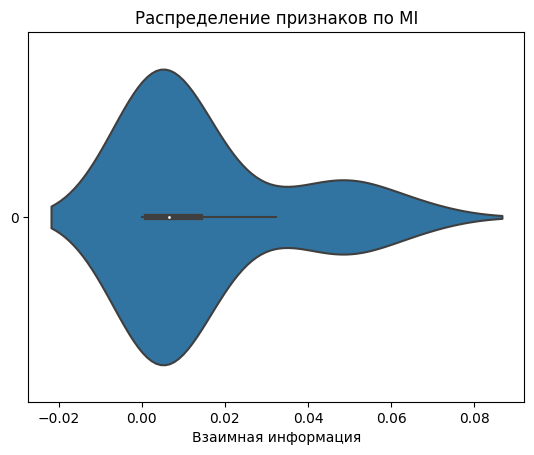

In [34]:
mi_scores = mutual_info_classif(clean_df.drop('Churn', axis=1), clean_df['Churn'], random_state=RANDOM_STATE)
sns.violinplot(data=mi_scores, orient='h').set(title='Распределение признаков по MI', xlabel='Взаимная информация');

In [35]:
mic_data = pd.DataFrame()
mic_data['feature'] = clean_df.drop('Churn', axis=1).columns
mic_data['MIC'] = mi_scores
  
mic_data.sort_values(by='MIC', ascending=False)

,feature,MIC
15,HasContractPhone_Two year,0.064821
6,HasInternetService_Fiber optic,0.049308
20,svd,0.048891
18,PaymentMethod_Electronic check,0.048073
7,HasInternetService_No,0.032384
16,IsBillingPaperless_Yes,0.013923
14,HasContractPhone_One year,0.013780
17,PaymentMethod_Credit card (automatic),0.009770
1,IsSeniorCitizen_Yes,0.009680
3,HasChild_Yes,0.009507


Часть признаков практически не связана с целевым по этому критерию - их можно будет исключить из модели.

In [36]:
recommended_columns = mic_data[mic_data['MIC'] > 0]['feature'].to_list()

### Variance Inflation Factor

In [37]:
vif_data = pd.DataFrame()
vif_data['feature'] = recommended_columns
vif_data['VIF'] = [variance_inflation_factor(clean_df[recommended_columns].values, i) for i in range(len(recommended_columns))]
  
vif_data.sort_values(by='VIF', ascending=False)

,feature,VIF
16,svd,6.900038
3,HasInternetService_Fiber optic,3.069324
11,HasContractPhone_Two year,2.925801
9,HasMovieSubscription_Yes,2.810967
8,HasOnlineTV_Yes,2.751635
1,HasPartner_Yes,2.727730
12,IsBillingPaperless_Yes,2.600585
6,HasDeviceProtection_Yes,2.312044
4,HasInternetService_No,2.268446
5,HasOnlineBackup_Yes,2.154597


После наших операций VIF ни у одного признака не превысит 10 - результат более чем удовлетворительный!

### (Дополнительно) Визуализация малой размерностью

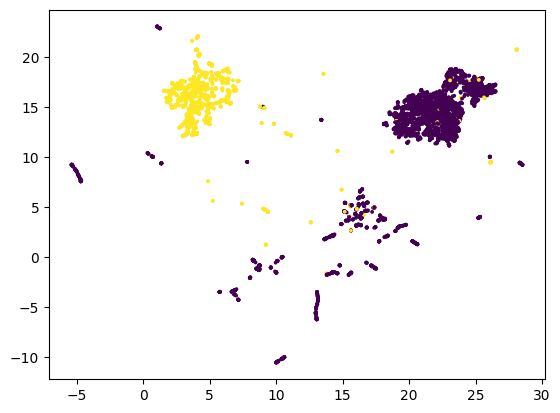

In [38]:
embedding = umap.UMAP(n_components=2, random_state=RANDOM_STATE).fit(QuantileTransformer(random_state=RANDOM_STATE).fit_transform(clean_df[recommended_columns]), clean_df[target_col])
plt.scatter(embedding.embedding_[:, 0], embedding.embedding_[:, 1], c=clean_df[target_col], s=3);

В целом неплохо: большинство наблюдений собираются в 2-3 компактные группы по нашей выборке признаков.

# Моделирование

## Разбиение на выборки

Выделим валидационную выборку в размере 10% от датасета:

In [39]:
features_train, features_test, target_train, target_test = train_test_split(data[num_cols+cat_cols], data[target_col], test_size=0.1, random_state=RANDOM_STATE, shuffle=True)

In [40]:
# Раскомментируйте, чтобы зафитить данные целиком (корректность проверки на валидационной выборке не будет соблюдена).
'''
features_train = data[num_cols+cat_cols]
features_test = data[num_cols+cat_cols]
target_train = data[target_col]
target_test = data[target_col]
'''

'\nfeatures_train = data[num_cols+cat_cols]\nfeatures_test = data[num_cols+cat_cols]\ntarget_train = data[target_col]\ntarget_test = data[target_col]\n'

## Baseline

Проверим нижний порог качества с помощью нескольких фиктивных моделей:

In [41]:
for strategy in ['uniform','most_frequent','stratified','prior']:
    dummy = DummyClassifier(strategy=strategy, random_state=RANDOM_STATE)
    dummy.fit(features_train, target_train)

    dummy_predictions = dummy.predict(features_test)
    dummy_probabilities = dummy.predict_proba(features_test)[:, 1]
   
    if np.count_nonzero(dummy_predictions == 1) > 0:
        dummy_f1 = f1_score(target_test, dummy_predictions)
    else:
        dummy_f1 = 0
        
    dummy_roc_auc = roc_auc_score (target_test, dummy_probabilities)
    dummy_accuracy = accuracy_score(target_test, dummy_predictions)
    
    print(f'Стратегия: {strategy}, F1: {dummy_f1:.2f}, ROC_AUC: {dummy_roc_auc:.2f}, accuracy {dummy_accuracy:.0%}.')

Стратегия: uniform, F1: 0.35, ROC_AUC: 0.50, accuracy 49%.
Стратегия: most_frequent, F1: 0.00, ROC_AUC: 0.50, accuracy 73%.
Стратегия: stratified, F1: 0.27, ROC_AUC: 0.51, accuracy 62%.
Стратегия: prior, F1: 0.00, ROC_AUC: 0.50, accuracy 73%.


Ничего неожиданного: accuracy не превышает доли доминирующего класса, а ROC_AUC, как и положено, около 0.5.

## Линейная модель

Организуем конвейер следующим образом:
1. Предобработка:
    - кодирование категориальных переменных: one-hot encoding либо реализация CatBoostEncoder из библиотеки category_encoders;
    - слияние численных переменных через `TruncatedSVD()`.

2. Feature selection: из получившихся столбцов возьмем только признаки с ненулевой мерой взаимной информации с целевым.

3. Масштабирование: на выбор классические скейлеры sklearn, преобразования Бокса-Кокса через `PowerTransformer()` и оба вида `QuantileTransformer()`. Категории попадут под шкалирование тоже - от простых методов они не пострадают, а сложные могут дать и положительный эффект (принцип scale the features uniformily)).

4. Классификатор.

Наилучшие гиперпараметры предобрабоки и классификатора будем подбирать с помощью `BayesSearchCV()` из библиотеки scikit-optimize.

In [42]:
# Реализация критерия взаимной информации для SelectFromModel():
class MutualInfoEstimator(BaseEstimator):
    def __init__(self):
        ...

    def fit(self, X, y):
        self.feature_importances_ = mutual_info_classif(X, y, random_state=RANDOM_STATE)

In [43]:
selector = SelectFromModel(estimator=MutualInfoEstimator(), threshold=1e-4)

In [44]:
# Список энкодеров:
encoder_list = (
                   OneHotEncoder(handle_unknown="ignore", drop='first'),
                   CatBoostEncoder(random_state=RANDOM_STATE),
               )

# Список скейлеров:
scaler_list = [Normalizer(),
               MinMaxScaler(),
               StandardScaler(),
               RobustScaler(),
               PowerTransformer(),
               QuantileTransformer(random_state=RANDOM_STATE),
               QuantileTransformer(random_state=RANDOM_STATE, output_distribution='normal')]

# Предобработка по группам признаков:
transformers = [
                   ("encoder", OneHotEncoder(handle_unknown="ignore", drop='first'), cat_cols),
                   ("svd", TruncatedSVD(n_components=1), num_cols),
               ]

preprocessor = ColumnTransformer(transformers=transformers, remainder='passthrough', n_jobs=-1)

In [45]:
def optimize(model, params, X, y):
    name = f'{type(model).__name__}'
    print(f'Оптимизация {name}...')
    pipe = Pipeline([
                        ('preprocessor', preprocessor),
                        ('selector', selector),
                        ('scaler', StandardScaler()),
                        ('classifier', model)
                    ])
    gcv = BayesSearchCV(pipe, search_spaces=params, cv=5, scoring='roc_auc', random_state=RANDOM_STATE, n_jobs=-1)
    gcv.fit(X, y)
    print(f'Лучшие гиперпараметры: {dict(gcv.best_params_)}')
    print(f'ROC_AUC: {(gcv.best_score_):.2f}')
    return gcv.best_estimator_

In [46]:
%%time
linear_params = {
                    'scaler': Categorical(scaler_list),
                    'preprocessor__encoder' : Categorical(encoder_list),
                    'classifier__fit_intercept':Categorical([True, False]),
                    'classifier__l1_ratio':Real(0, 1, prior='uniform'),
                    'classifier__class_weight':Categorical([None, 'balanced']),
                    'classifier__C': Real(1e-3, 1e+3, prior='log-uniform'),
                }
best_linear = optimize(LogisticRegression(n_jobs=-1, random_state=RANDOM_STATE, solver='saga', penalty='elasticnet', max_iter=10000), linear_params, features_train, target_train)

Оптимизация LogisticRegression...
Лучшие гиперпараметры: {'classifier__C': 1000.0, 'classifier__class_weight': None, 'classifier__fit_intercept': True, 'classifier__l1_ratio': 1.0, 'preprocessor__encoder': OneHotEncoder(drop='first', handle_unknown='ignore'), 'scaler': QuantileTransformer(output_distribution='normal', random_state=177013)}
ROC_AUC: 0.84
CPU times: user 2min 41s, sys: 1min 12s, total: 3min 53s
Wall time: 1min 11s


### Проверка на валидационой выборке

In [47]:
def calculate_metrics(probabilities, target_test):
    predictions = (probabilities > 0.5)
    f1 = f1_score(target_test, predictions)
    roc_auc = roc_auc_score(target_test, probabilities)
    acc = accuracy_score(target_test, predictions)
    ap = average_precision_score(target_test, probabilities)
    cmatrix = confusion_matrix(target_test, predictions)
    
    fpr, tpr, _ = roc_curve(target_test, probabilities)
    precision, recall, thresholds = precision_recall_curve(target_test, probabilities)
    f1_scores = 2 * recall * precision / (recall + precision)
    f1_scores = np.nan_to_num(f1_scores)
    best_f1 = np.max(f1_scores)
    best_thresh = thresholds[np.argmax(f1_scores)]

    pred_t = (probabilities > best_thresh)
    best_cmatrix = confusion_matrix(target_test, pred_t)
    
    return f1, best_f1, roc_auc, acc, ap, best_thresh, fpr, tpr, recall, precision, cmatrix, best_cmatrix

def visualize_tests(probabilities, target_test):
    cmatrices = []

    fig, axes = plt.subplots(1, 2, figsize=(15,6))
    axes[0].plot([0, 1], linestyle='--')
    axes[1].plot([0.5, 0.5], linestyle='--')

    f1, best_f1, roc_auc, acc, ap, best_thresh, fpr, tpr, recall, precision, cmatrix, best_cmatrix = calculate_metrics (probabilities, target_test)
    axes[0].plot (fpr, tpr);
    axes[1].plot (recall, precision);
    print (f'F1: {f1:.2f} (макс. {best_f1:.2f} с порогом {best_thresh:.2f}), ROC_AUC: {roc_auc:.3f}, accuracy: {acc:.0%}, AP (PR_AUC): {ap:.2f}')
    cmatrices.append(cmatrix)
    cmatrices.append(best_cmatrix)
    
    axes[0].set (xlabel='FPR', ylabel='TPR', title='ROC-кривая', xlim=(0,1), ylim=(0,1))
    axes[1].set (xlabel='Recall', ylabel='Precision', title='PR-кривая', xlim=(0,1), ylim=(0,1))
    
    fig, axes = plt.subplots(1, 2, figsize=(13, 5), constrained_layout=True)
    for cmatrix, ax, title in zip(cmatrices, axes.flat, ['Матрица ошибок', 'Матрица ошибок (оптимальный порог)']):
        sns.heatmap(cmatrix, ax=ax, annot=True, cmap='Blues', fmt='d').set(title=title, xlabel='Предсказание', ylabel='Реальность')
    
    return best_thresh

F1: 0.62 (макс. 0.64 с порогом 0.30), ROC_AUC: 0.850, accuracy: 81%, AP (PR_AUC): 0.69


0.29828338478812755

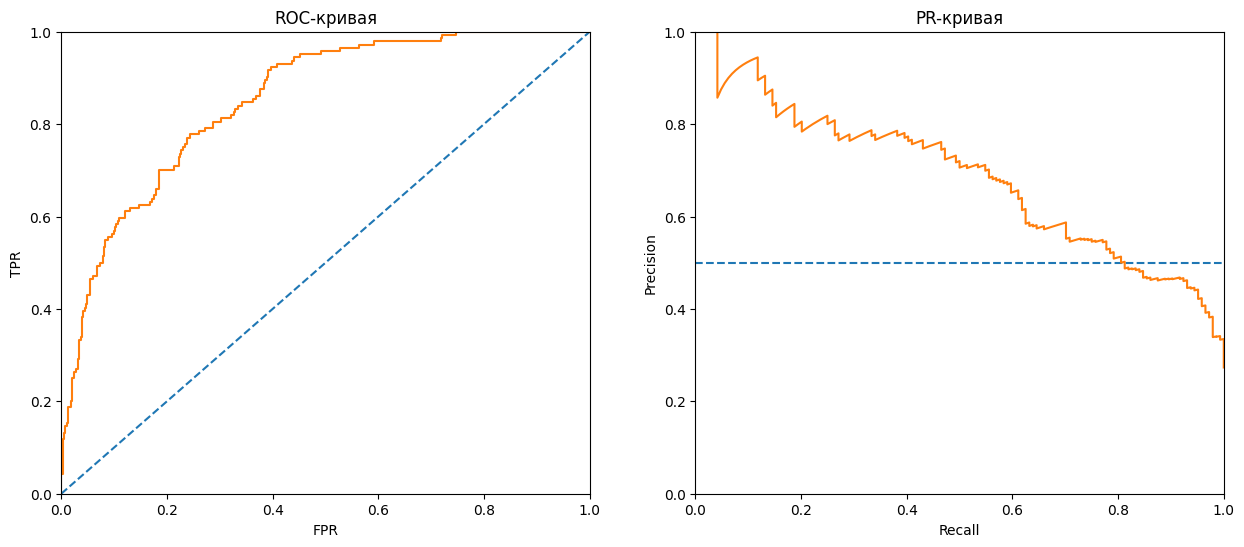

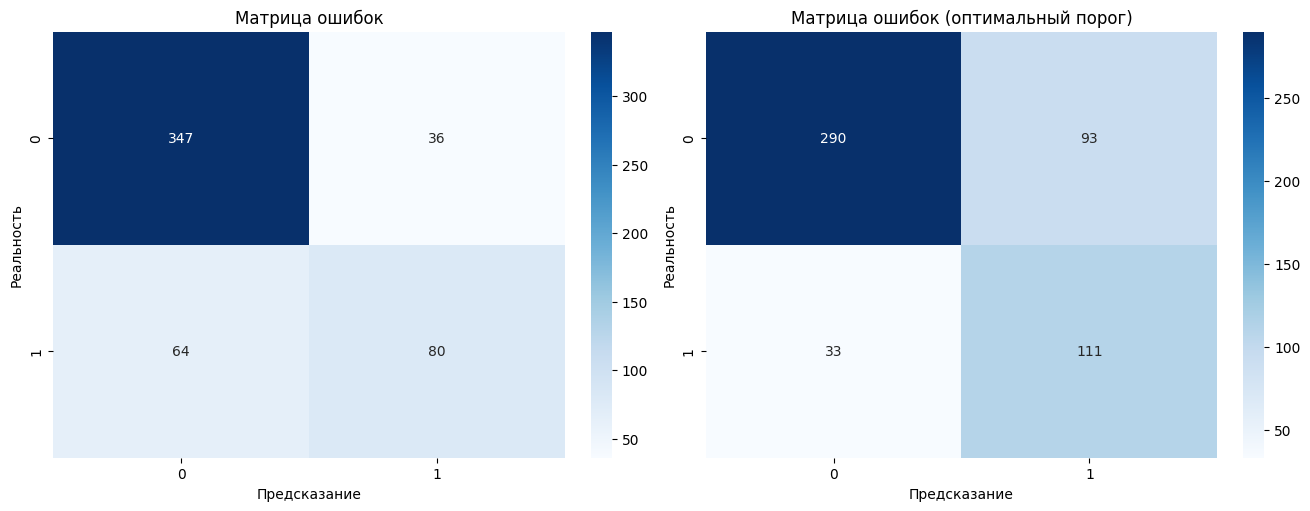

In [48]:
lr_probs = best_linear.predict_proba(features_test)[:,1]
visualize_tests(lr_probs, target_test)

Модель справляется неплохо, достигая порядка 0.85 ROC_AUC и 0.64 F1. С оптимальным порогом для F1-меры модель способна "подсветить" порядка 70-75% реально уходящих клиентов, однако precision оставляет желать лучшего: около 55%.

Оптимальным гиперпараметром оказалась слабая L1-регуляризация, развесовка влияет слабо и может дать как лучший, так и худший результат в зависимости от обучающей выборки. One-hot encoding и нормализация распределения показали себя самыми оптимальными методами предобработки, несмотря на то, что последняя слегка нарушает линейные зависимости.

## Модель градиентного бустинга

Для CatBoost мы используем тот же конвейер (для унификации используем CatBoostEncoder, хотя это в принципе необязательно: для бинарных признаков CatBoost все равно использовал бы one-hot кодирование, а для остальных разновидность target encoding'а).

In [49]:
%%time
cat_params = {
                    'scaler': Categorical(scaler_list),
                    'preprocessor__encoder' : Categorical(encoder_list),
                    'classifier__auto_class_weights': Categorical(['None', 'Balanced', 'SqrtBalanced']),
                    'classifier__depth':Integer(1,5),
                    'classifier__learning_rate' : Real(1e-2, 1.0, prior='uniform'),
                    'classifier__iterations'    : Integer(10, 1000),
                    'classifier__l2_leaf_reg' : Integer(1,10),
                }
best_cat = optimize(CatBoostClassifier(random_state=RANDOM_STATE, verbose=0), cat_params, features_train, target_train)

Оптимизация CatBoostClassifier...
Лучшие гиперпараметры: {'classifier__auto_class_weights': 'Balanced', 'classifier__depth': 3, 'classifier__iterations': 541, 'classifier__l2_leaf_reg': 6, 'classifier__learning_rate': 0.01, 'preprocessor__encoder': OneHotEncoder(drop='first', handle_unknown='ignore'), 'scaler': StandardScaler()}
ROC_AUC: 0.85
CPU times: user 3min 30s, sys: 1min 41s, total: 5min 12s
Wall time: 12min 51s


F1: 0.63 (макс. 0.65 с порогом 0.59), ROC_AUC: 0.851, accuracy: 74%, AP (PR_AUC): 0.68


0.5891717201592943

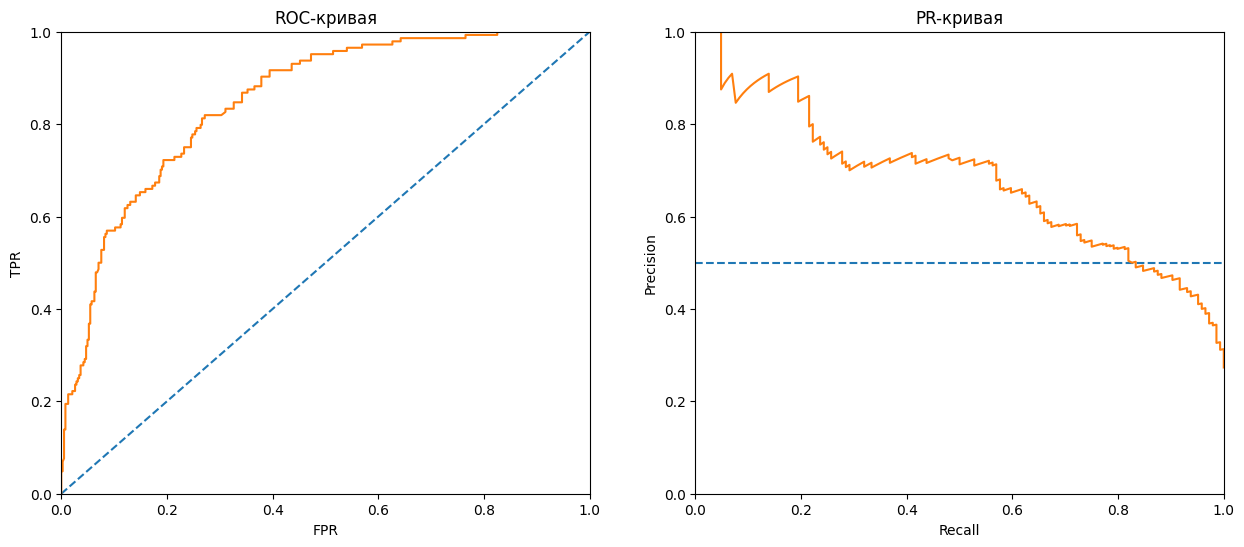

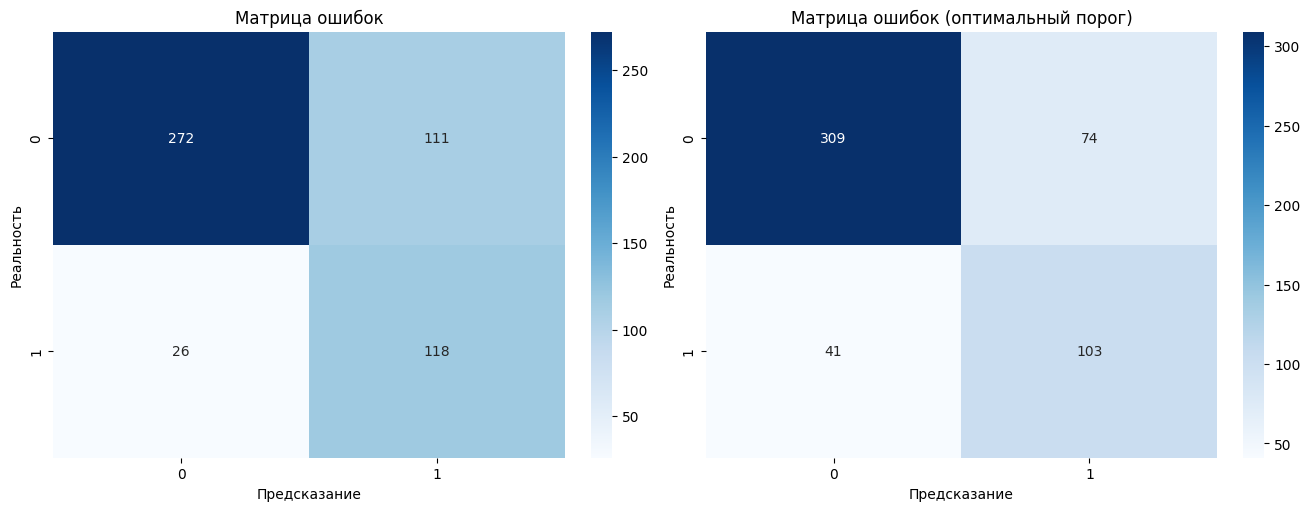

In [50]:
cat_probs = best_cat.predict_proba(features_test)[:,1]
visualize_tests(cat_probs, target_test)

Модель обходит линейную очень незначительно по ROC_AUC и чуть заметнее по метрикам матрицы ошибок, позволяя добиться хорошего recall'а (выше 80%) при precision около 50% либо чуть более сбалансированного варианта при оптимальном среднегармоническом пороге. В данном случае развесовка позволяет немного улучшить метрику, оптимальная высота дерева не превышает 3 при нескольких сотнях деревьев, а one-hot encoding и здесь показывает себя лучше более сложных методов. Влияние масштабирования на деревянные модели незначительно, но все же `StandardScaler()`/`RobustScaler()` отрабатывают немного лучше.

## Ансамблирование

По итогу модель градиентного бустинга чуть впереди линейной, но ненамного. Почему бы не использовать обе? Протестируем два ансамбля: на базе голосования и простой метамодели.

In [51]:
voters = [('lr', best_linear), ('gb',best_cat)]
vote = VotingClassifier(estimators=voters, n_jobs=-1, voting='soft')

In [52]:
stack = StackingClassifier(estimators=voters, final_estimator=LogisticRegression(), cv=5, n_jobs=-1)

F1: 0.62 (макс. 0.65 с порогом 0.42), ROC_AUC: 0.851, accuracy: 77%, AP (PR_AUC): 0.69


0.42280551555702434

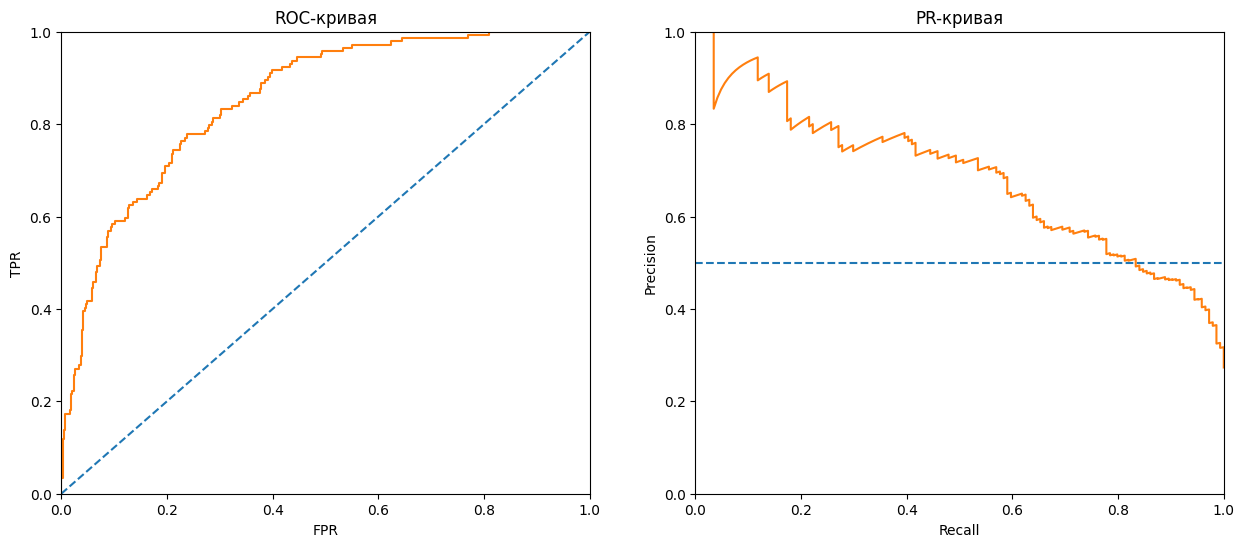

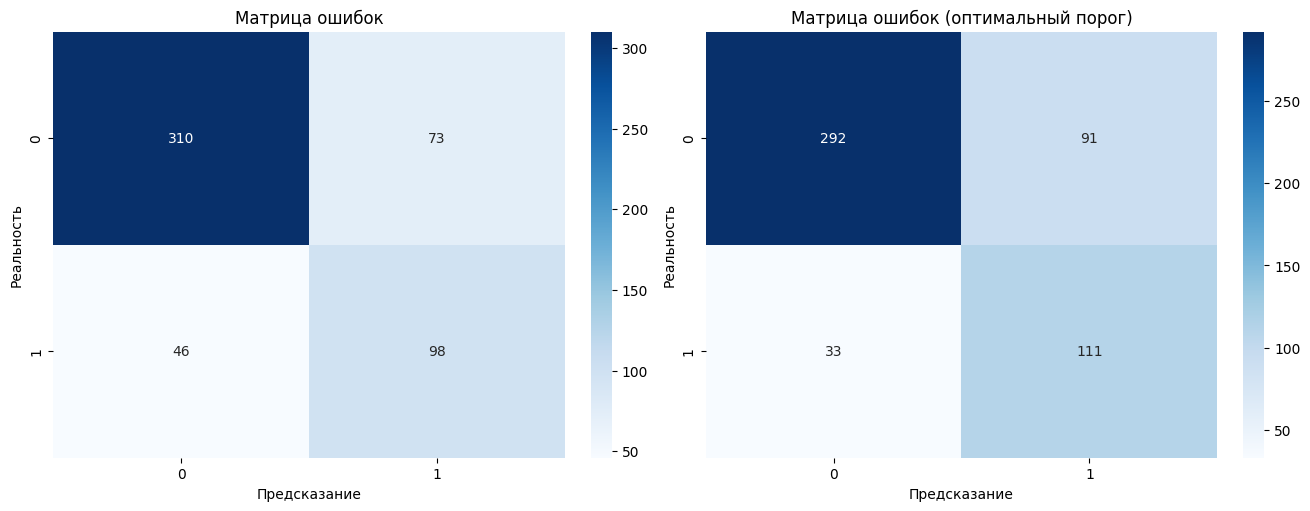

In [53]:
vote.fit(features_train, target_train)
vote_probs = vote.predict_proba(features_test)[:,1]
visualize_tests(vote_probs, target_test)

F1: 0.62 (макс. 0.65 с порогом 0.32), ROC_AUC: 0.851, accuracy: 81%, AP (PR_AUC): 0.68


0.32398633009742456

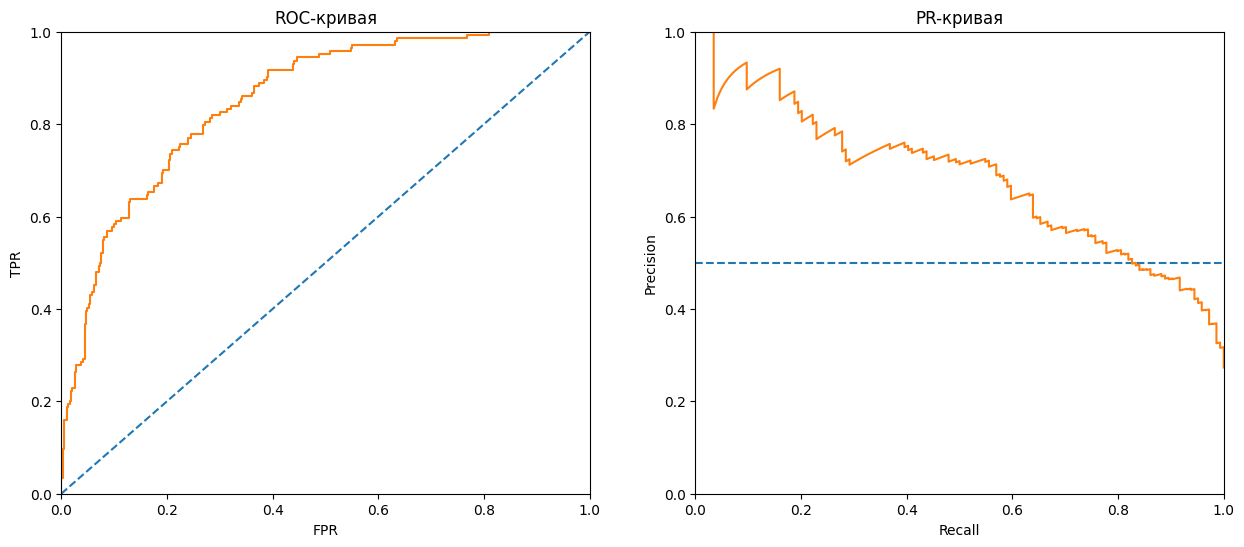

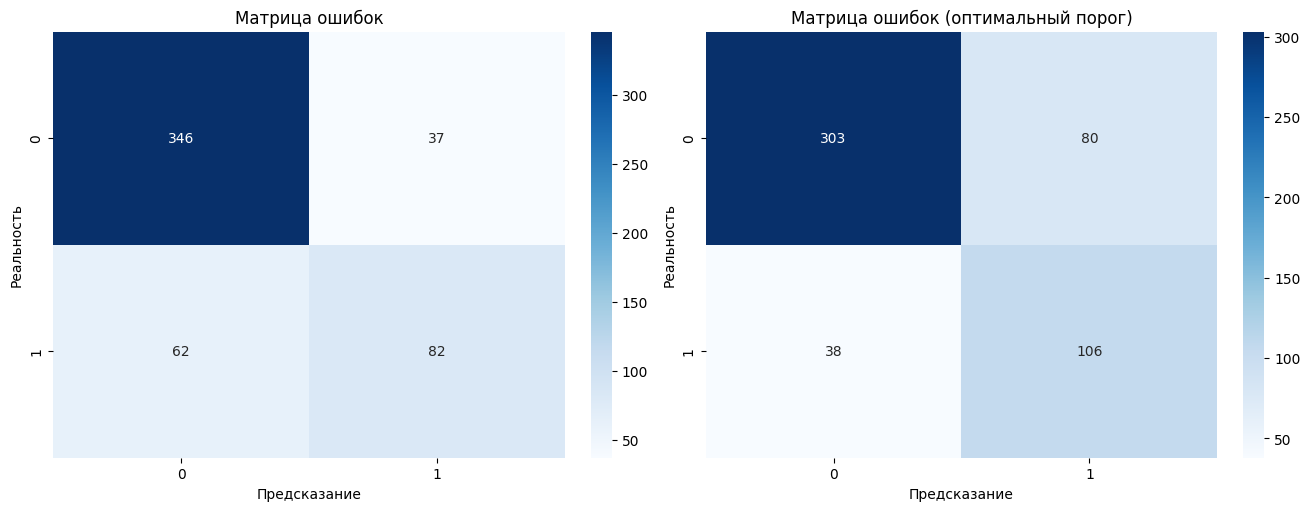

In [54]:
stack.fit(features_train, target_train)
stack_probs = stack.predict_proba(features_test)[:,1]
visualize_tests(stack_probs, target_test)

При оптимальном пороге результат очень близкий, реальная разница наблюдается лишь на тестировании kaggle: ансамбли самую чуточку впереди.

## Использование признаков в моделях

In [55]:
models = [best_linear, best_cat]
model_legend = [type(model['classifier']).__name__ for model in models]

In [56]:
def importance_summary(model_list, X_test, y_test, feature_names):
    importances = pd.DataFrame()
    
    for model in model_list:
        importance = permutation_importance(model,
                                            X_test,
                                            y_test,
                                            random_state=RANDOM_STATE, scoring='roc_auc').importances_mean
        importances = importances.append (pd.Series(importance, index=feature_names),
                                          ignore_index=True)
    
    importances = importances.div(importances.sum (axis=1), axis=0)
    importances.T.plot(kind='bar', figsize=(10,5), width=0.7).set(title="Feature importance",
                                                                  ylabel="Влияние признаков (нормализовано)");
    plt.legend(model_legend);

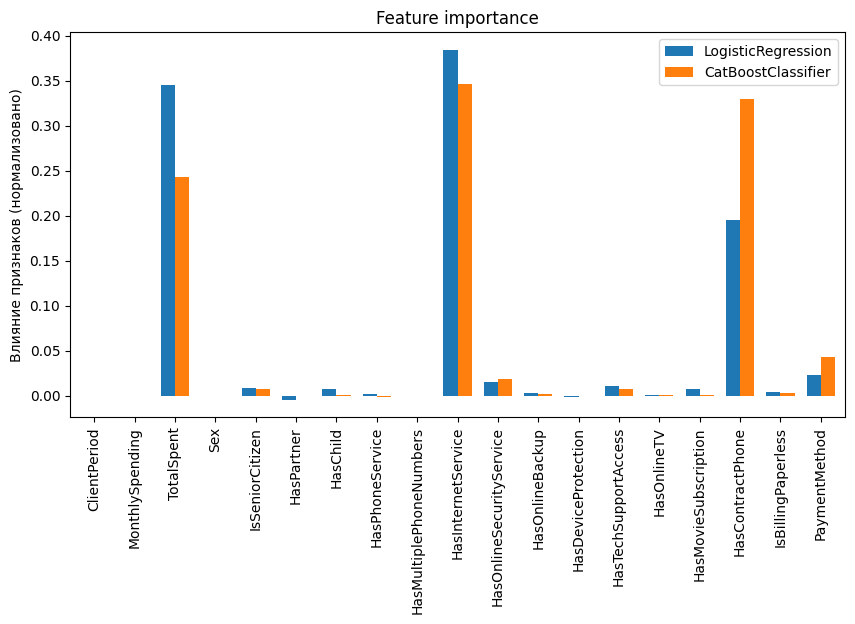

In [57]:
importance_summary(models, features_test, target_test, list(features_train.columns))

Картина сходная: расходы клиента важны (здесь понижение размерности несколько смазывает интерпретацию), предоставление услуг интернета и аренды телефона тоже - неплохие способы привязать клиента! Допуслуги и семейное положение влияют мало, признаки, вылетевшие по критерию взаимной информации, понятно, уже никак не влияют.

# Общий вывод

Мы проанализировали данные и испытали две модели классификации (логистическую регрессию и модуль градиентного бустинга CatBoost). По итогам подбора оптимальных гиперпараметров обе модели и любые их комбинации отвечают требованиям техзадания с близким показателем метрики ROC_AUC порядка 0.85 и F1 в пределах 0.65.

С практической точки зрения это означает, что:
 - при оптимальном пороге F1-меры из клиентов, действительно собирающихся уйти, модели способны выявить до 80%, позволив оператору отреагировать и попытаться сохранить их, но ценой достаточно большого числа ложных срабатываний (порядка 50%).
 - при сравнении двух случайных клиентов, один из которых в реальности собирается сменить оператора, а другой - нет, модель верно выдаст для первого более высокий скор в 85% случаев.

# Предсказания

In [58]:
best_model = vote

In [59]:
X_test = pd.read_csv('test.csv')

In [60]:
# Процедуры предварительной предобработки:
X_test['IsSeniorCitizen'] = X_test['IsSeniorCitizen'].map(lambda x: 'Yes' if x else 'No')
fill_vector_test = X_test.apply(lambda row: row['MonthlySpending'] * row['ClientPeriod'], axis=1)
X_test['TotalSpent'] = pd.to_numeric(X_test['TotalSpent'].str.strip()).fillna(fill_vector_test)
X_test = X_test.pipe(eliminate_redundancy, columns_with_redundancy)

In [78]:
joint_features = pd.concat([features_train, X_test])
joint_target = pd.concat([target_train, pd.Series([-1 for _ in range(len(X_test))])])

In [61]:
submission = pd.read_csv('./submission.csv', index_col='Id')

In [62]:
submission['Churn'] =  best_model.predict_proba(X_test)[:,1]

In [63]:
submission.head()

,Churn
Id,
0,0.081121
1,0.732699
2,0.694906
3,0.030582
4,0.015093


In [64]:
submission.to_csv('my_submission.csv')

Эта версия достигает результата 0.85442 ROC_AUC на тесте kaggle (при условии обучения на всем датасете, в противном случае чуть ниже 0.85).